# Proyek Klasifikasi Gambar: 1000 Pokemon Dataset
- **Nama:** Robert Varian
- **Email:** mc827d5y0604@student.devacademy.id
- **ID Dicoding:** mc827d5y0604

## Import Semua Packages/Library yang Digunakan

In [2]:
#untuk penyimpanan gambar
import os, shutil
import zipfile
import random
from random import sample
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import matplotlib.pyplot as plt
import seaborn as sns
# untuk proses gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
# untuk membangun model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

## Data Preparation

### Data Loading

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"grandhavoc","key":"53aad8c892f982db09c5547e125582c7"}'}

In [3]:
!pip install -q kaggle

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors


In [6]:
!unzip intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [14]:
try:
    shutil.rmtree('seg_pred')
    print("Directory 'seg_pred' removed successfully.")
except OSError as e:
    print(f"Error: {e}")

Directory 'seg_pred' removed successfully.


In [15]:
train_dir = "seg_train/seg_train"
test_dir = "seg_test/seg_test"

combined_dir = "seg_dataset/seg_dataset"

In [16]:
os.makedirs(combined_dir, exist_ok=True)

In [17]:
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

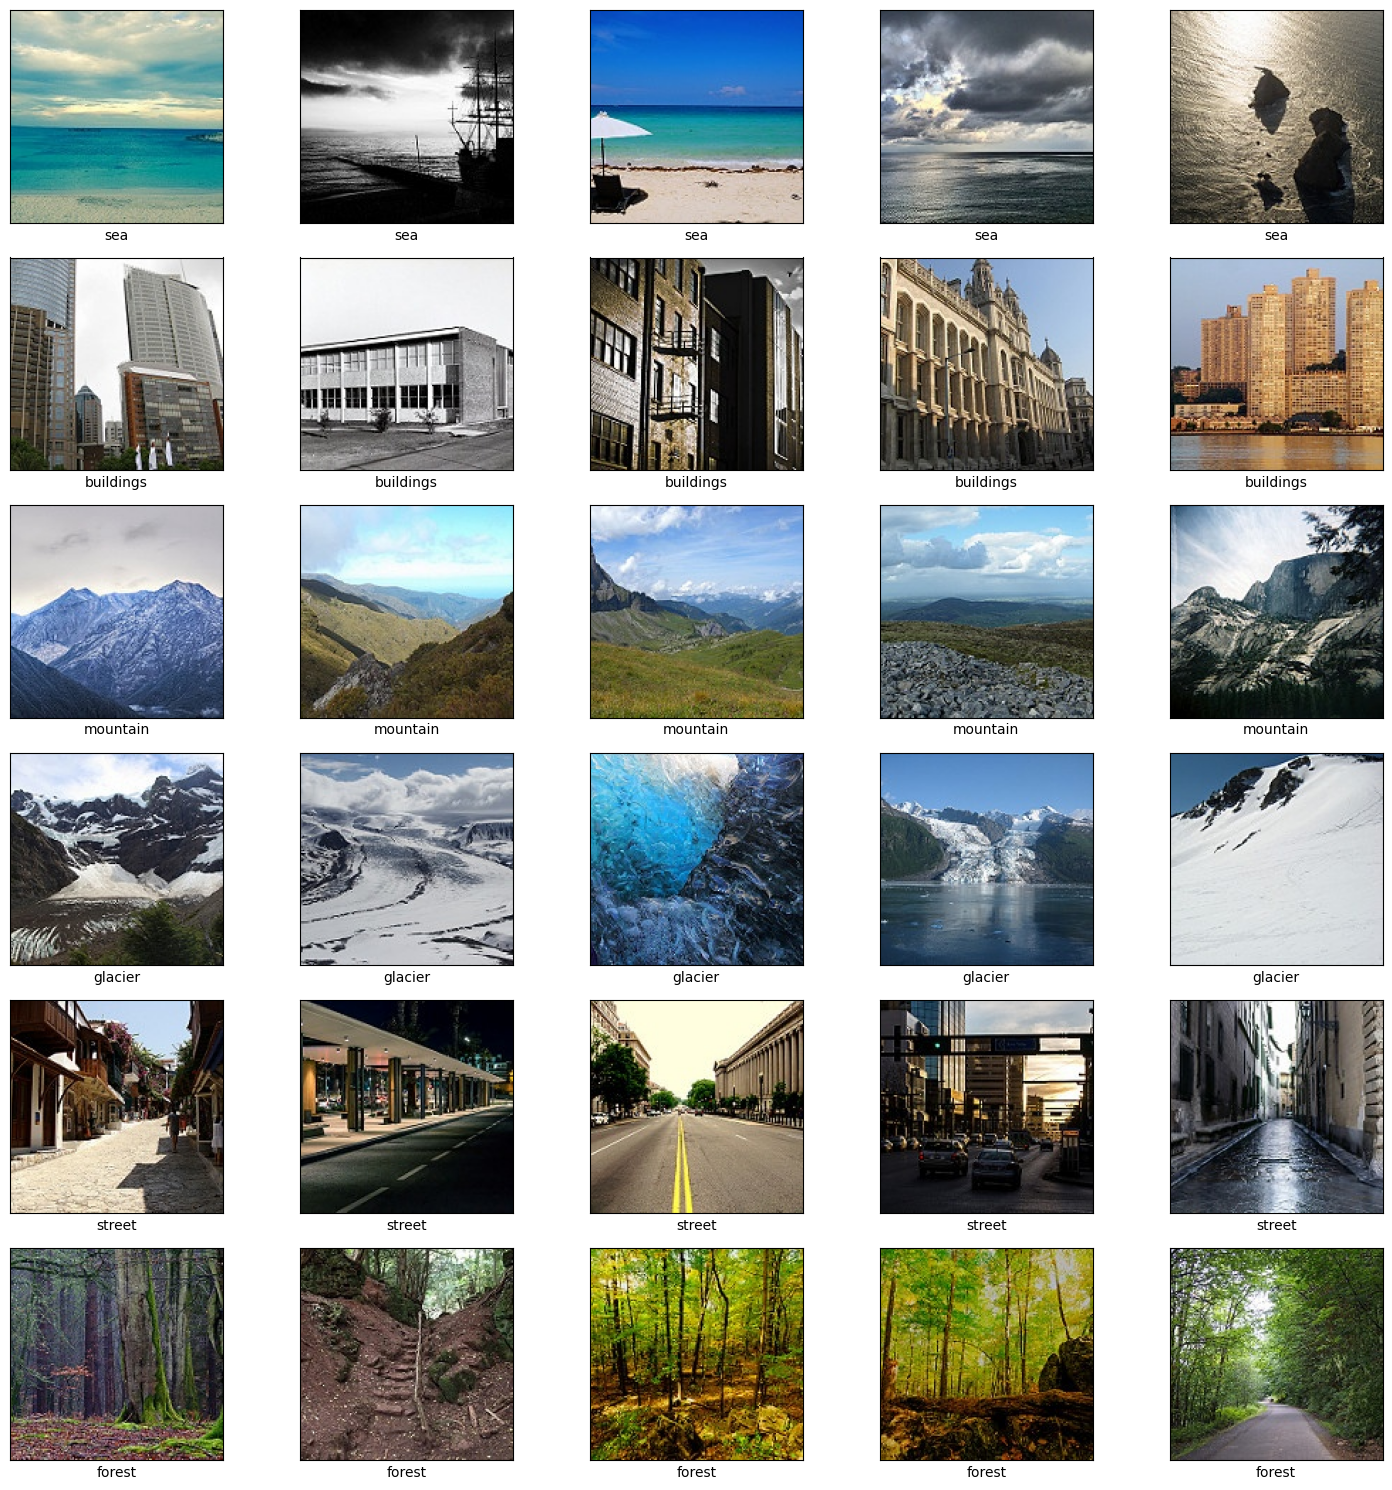

In [21]:
# kamus untuk menyimpan gambar setiap kelas dalam data intel
intel_images = {}

#tentukan path sumber image
path = "seg_dataset/"
path_sub = os.path.join(path, "seg_dataset")
for i in os.listdir(path_sub):
  intel_images[i] = os.listdir(os.path.join(path_sub, i))

#menampilkan secara acak 2 gambar untuk setiap kelas
path_sub = "seg_dataset/seg_dataset/"

k=0

fig, axs = plt.subplots(len(intel_images.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(intel_images[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("RGB")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

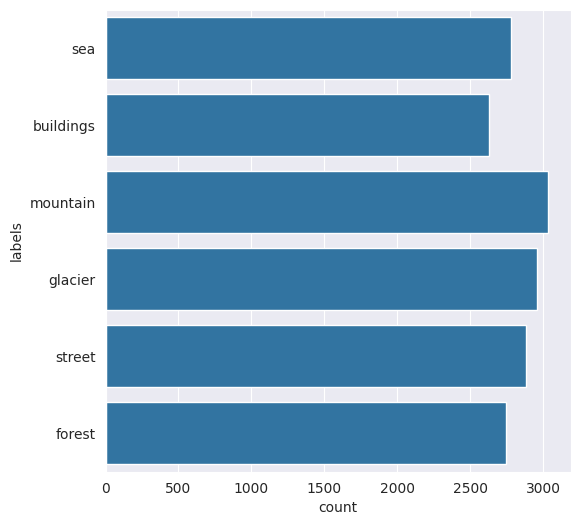

In [23]:
intel_path = "seg_dataset/seg_dataset"

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(intel_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

### Data Preprocessing

In [6]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, sudut)

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

In [7]:
#pengecekan label yang ada pada dataset
mypath = 'seg_dataset/seg_dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

df = pd.DataFrame({'path': full_path,'file_name': file_name, 'label': labels})
df.groupby(['label']).size()

,0
label,
buildings,2628
forest,2745
glacier,2957
mountain,3037
sea,2784
street,2883


#### Split Dataset

In [8]:
x = df['path']
y = df['label']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=48)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=48)

print('train data:', len(x_train))
print('validation data:', len(x_val))
print('test data:', len(x_test))

train data: 10901
validation data: 2726
test data: 3407


In [5]:
df_train = pd.DataFrame({'path':x_train,'label':y_train,'set':'train'})
df_val = pd.DataFrame({'path':x_val,'label':y_val,'set':'val'})
df_test = pd.DataFrame({'path':x_test,'label':y_test,'set':'test'})

In [9]:
df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)
print('===================================================== \n')
print(df_all.groupby(['set', 'label']).size(), '\n')
print('===================================================== \n')

print(df_all.sample(5))

data_path = 'pokemon-dataset-1000/dataset/'
dataset_path = 'datafinal/'


set    label    
test   buildings     519
       forest        545
       glacier       581
       mountain      605
       sea           580
       street        577
train  buildings    1686
       forest       1737
       glacier      1915
       mountain     1964
       sea          1772
       street       1827
val    buildings     423
       forest        463
       glacier       461
       mountain      468
       sea           432
       street        479
dtype: int64 


                                             path      label    set
9371     seg_dataset/seg_dataset/forest/12610.jpg     forest  train
10907  seg_dataset/seg_dataset/buildings/8623.jpg  buildings    val
7833   seg_dataset/seg_dataset/buildings/5313.jpg  buildings  train
2204      seg_dataset/seg_dataset/forest/8857.jpg     forest  train
16821    seg_dataset/seg_dataset/forest/19864.jpg     forest   test


In [10]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(data_path,row['label'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['label'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['label']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['label'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

## Modelling

In [11]:
TRAIN_DIR = "datafinal/train/"
TEST_DIR = "datafinal/test/"
VAL_DIR = "datafinal/val/"

train_pokemon = os.path.join(TRAIN_DIR)
test_pokemon = os.path.join(TEST_DIR)
val_pokemon = os.path.join(VAL_DIR)

print("Total kelas data di set training: ",len(os.listdir(train_pokemon)))
print("Total kelas data di set test: ",len(os.listdir(test_pokemon)))
print("Total kelas data di set validation: ",len(os.listdir(val_pokemon)))

Total kelas data di set training:  6
Total kelas data di set test:  6
Total kelas data di set validation:  6


In [12]:
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="rgb",
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(VAL_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                   color_mode="rgb",
                                                   class_mode="categorical",
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="rgb",
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 8723 images belonging to 6 classes.
Found 542 images belonging to 6 classes.
Found 3407 images belonging to 6 classes.


In [17]:
model_klasifikasi = Sequential()

model_klasifikasi.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3),padding='same'))
model_klasifikasi.add(MaxPooling2D(2, 2))

model_klasifikasi.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model_klasifikasi.add(MaxPooling2D(2, 2))

model_klasifikasi.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
model_klasifikasi.add(MaxPooling2D(2, 2))

model_klasifikasi.add(Flatten())
model_klasifikasi.add(Dense(256, activation='relu'))
model_klasifikasi.add(Dropout(0.5))
model_klasifikasi.add(Dense(6, activation='softmax'))

model_klasifikasi.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0009),
              metrics=['accuracy'])

model_klasifikasi.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    10,617,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,711,878 (40.86 MB)

 Trainable params: 10,711,878 (40.86 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
%time

checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_1 = model_klasifikasi.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        callbacks=[checkpoint, early_stopping])


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs
Epoch 1/30
272/273 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4374 - loss: 1.4111
Epoch 1: val_accuracy improved from -inf to 0.67343, saving model to best_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.4382 - loss: 1.4092 - val_accuracy: 0.6734 - val_loss: 0.8501
Epoch 2/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7047 - loss: 0.8018
Epoch 2: val_accuracy improved from 0.67343 to 0.77675, saving model to best_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.7048 - loss: 0.8017 - val_accuracy: 0.7768 - val_loss: 0.5929
Epoch 3/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7857 - loss: 0.6033
Epoch 3: val_accuracy improved from 0.77675 to 0.81181, saving model to best_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.7857 - loss: 0.6032 - val_accuracy: 0.8118 - val_loss: 0.5412
Epoch 4/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8228 - loss: 0.5000
Epoch 4: val_accuracy did not improve from 0.81181
273/273 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.8228 - loss: 0.5000 - val_accuracy: 0.8007 - val_loss: 0.5366
Epoch 5/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8589 - loss: 0.4011
Epoch 5: val_accuracy improved from 0.81181 to 0.83948, saving model to best_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.8588 - loss: 0.4011 - val_accuracy: 0.8395 - val_loss: 0.4800
Epoch 6/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8780 - loss: 0.3400
Epoch 6: val_accuracy did not improve from 0.83948
273/273 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.8781 - loss: 0.3400 - val_accuracy: 0.8284 - val_loss: 0.5612
Epoch 7/30
272/273 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9172 - loss: 0.2400
Epoch 7: val_accuracy did not improve from 0.83948
273/273 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.9172 - loss: 0.2401 - val_accuracy: 0.8284 - val_loss: 0.5726
Epoch 8/30
272/273 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9335 - loss: 0.1890
Epoch 8: val_accuracy did not improve from 0.83948
273/273 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.9335 - loss: 0.1890 - val_accuracy: 0.8321 - val_loss: 0.6116
Epoch 9/30
272/273 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9448 - loss: 0.1655
Epoch 9: val_accuracy d

## Evaluasi dan Visualisasi

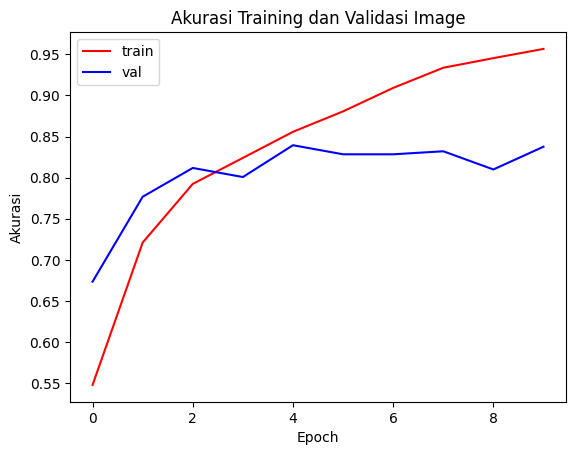

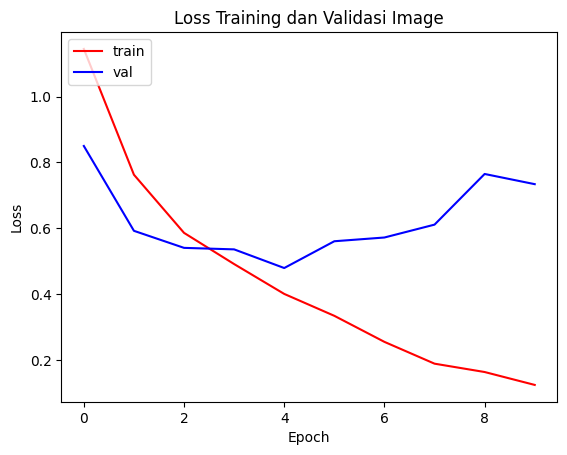

In [19]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Akurasi Training dan Validasi Image')
plt.ylabel('Akurasi')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Loss Training dan Validasi Image')
plt.show()

Terlihat dari plot diatas dimana akurasi train dan validasi naik setelah epoch 1 dan kemudian mulai melambat setelah epoch 2 dimana akurasinya berupa 0.8 untuk val dan epoch 7 dimana akurasinya berupa +- 0.92 untuk train.


Terlihat juga dari plot diatas dimana loss train dan validasi turun tajam setelah epoch 1 dan kemudian mulai melambat pada epoch ke 2 dimana lossnya berupa 0.6 untuk val dan epoch 7 dimana lossnya berupa 0.2 untuk train.



              precision    recall  f1-score   support

   Buildings     0.8163    0.7707    0.7929       519
      Forest     0.9064    0.9596    0.9323       545
     Glacier     0.8154    0.7453    0.7788       581
    Mountain     0.7584    0.7835    0.7707       605
         Sea     0.7848    0.8552    0.8185       580
      Street     0.8533    0.8163    0.8344       577

    accuracy                         0.8210      3407
   macro avg     0.8224    0.8218    0.8212      3407
weighted avg     0.8212    0.8210    0.8202      3407



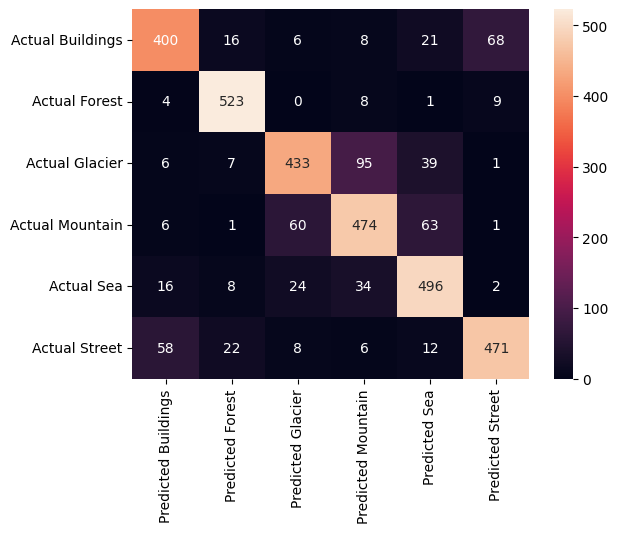

In [20]:
test_generator.reset()

prediksi = model_klasifikasi.predict(test_generator,verbose=0)

predicted_classes = np.argmax(prediksi, axis=1)

cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, predicted_classes, labels=[0, 1, 2, 3, 4, 5]), # Adjusted labels to match the number of classes
                  index=["Actual Buildings", "Actual Forest", "Actual Glacier", "Actual Mountain", "Actual Sea", "Actual Street"],
                  columns=["Predicted Buildings", "Predicted Forest", "Predicted Glacier", "Predicted Mountain", "Predicted Sea", "Predicted Street"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=predicted_classes,target_names =['Buildings','Forest','Glacier','Mountain','Sea','Street'], digits=4))

##### Untuk f1-score dapat dilihat bahwa:
1. Forest memiliki nilai tertinggi yaitu 0.9323
2. Street memiliki nilai kedua tertinggi yaitu 0.8344
3. Sea memiliki nilai ketiga tertinggi yaitu 0.8185
4. Buildings memiliki nilai keempat tertinggi yaitu 0.7929
5. Glacier memiliki nilai kelimat tertinggi yaitu 0.7788
6. Mountain memiliki nilai terendah yaitu 0.7707

##### Untuk Akurasinya lumayan baik karena mendapatkan +-82%

##### Untuk Confussion matrix terlihat terdapat beberapa salah deteksi seperti predicted glacier sebanyak 60 namun sebenarnya actual mountain, predicted glacier sebanyak 24 namun sebenarnya actual sea, predicted mountain sebanyak 34 namun sebenarnya actual sea, dan masih banyak lagi salah prediksinya. Namun hal tersebut wajar karena akurat deteksi disini hanya mendapatkan 82% saja

## Konversi Model

In [22]:
# !pip install tensorflowjs

!tensorflowjs_converter --input_format keras best_model.h5 tfjs_model

2025-04-22 17:14:15.069598: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745342055.113730   31474 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745342055.125640   31474 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [24]:
export_dir = 'saved_model/'
tf.saved_model.save(model_klasifikasi, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)



8612

In [31]:
!pip freeze requirements.txt

absl-py==1.4.0
accelerate==1.5.2
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.5
ale-py==0.10.2
altair==5.5.0
annotated-types==0.7.0
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.1
arviz==0.21.0
astropy==7.0.1
astropy-iers-data==0.2025.4.14.0.37.22
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==1.42.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blosc2==3.3.0
bokeh==3.6.3
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
CacheControl==0.14.2
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.1.31
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.89
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.21.0
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confe

## Inference (Optional)